In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

torchvision.disable_beta_transforms_warning()
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.v2 import Compose, ToImageTensor, ConvertImageDtype

In [3]:
MNIST_transform = Compose([ToImageTensor(), ConvertImageDtype(torch.float32)]) #scales between 0 and 1
mnist_train = torchvision.datasets.MNIST("../../datasets", train=True, download=True, transform=MNIST_transform)
mnist_test = torchvision.datasets.MNIST("../../datasets", train=False, download=True, transform=MNIST_transform)

<class 'torchvision.datapoints._image.Image'>
torch.float32
torch.Size([1, 28, 28])
<class 'int'>


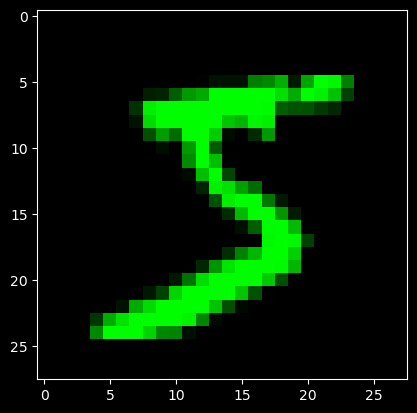

In [4]:
x_example, y_example = mnist_train[0]
print(type(x_example))
print(x_example.dtype)
print(x_example.shape)
print(type(y_example))

plt.imshow(x_example[0,:], cmap='gray')

x_example_green = torch.stack([x_example[0,:], x_example[0,:], x_example[0,:]])
x_example_green[0, :] = 0 #set R channel to zero
x_example_green[2, :] = 0 #set B channel to zero
plt.imshow(x_example_green.permute(1,2,0)) #imshow expects the channel dimension to be the last

In [5]:
n_train = len(mnist_train)
n_test = len(mnist_test)
im_width = x_example.shape[1]
im_height = x_example.shape[2]
x_type = np.float32 #recommended for PyTorch
y_type = np.int64 #recommended for PyTorch

x_train_shape = (n_train, im_width, im_height)
y_train_shape = n_train
x_test_shape = (n_test, im_width, im_height)
y_test_shape = n_test

In [6]:
from itertools import islice #allows us to first write only some examples
import os.path as path

mm_path = path.normpath("../../datasets/MNIST/raw/NumPy")

x_train_mm = np.memmap(path.join(mm_path, "X_train.dat"), dtype=x_type, mode='w+', shape=x_train_shape)
y_train_mm = np.memmap(path.join(mm_path, "y_train.dat"), dtype=y_type, mode='w+', shape=y_train_shape)

for i, example in enumerate(islice(mnist_train, n_train)):
    x_train_mm[i,:] = example[0].numpy()[:] #convert to np array reusing allocated storage
    y_train_mm[i] = example[1]

x_train_mm._mmap.close()
y_train_mm._mmap.close()

x_test_mm = np.memmap(path.join(mm_path, "X_test.dat"), dtype=x_type, mode='w+', shape=x_test_shape)
y_test_mm = np.memmap(path.join(mm_path, "y_test.dat"), dtype=y_type, mode='w+', shape=y_test_shape)

for i, example in enumerate(islice(mnist_test, n_test)):
    x_test_mm[i,:] = example[0].numpy()[:] #convert to np array reusing allocated storage
    y_test_mm[i] = example[1]

x_test_mm._mmap.close()
y_test_mm._mmap.close()

torch.float32
torch.int64
tensor(6)


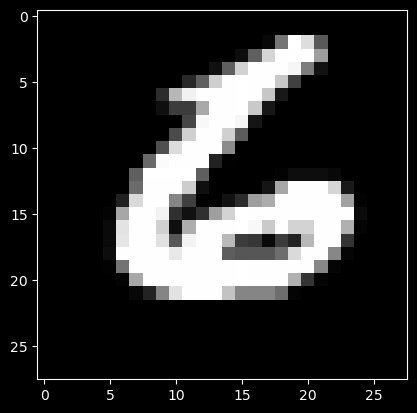

In [30]:
class LazyMNISTDataset(Dataset):

    def __init__(self, folder=mm_path, train=True):
        super(LazyMNISTDataset, self).__init__()
        if train:
            self.X = np.memmap(path.join(folder, "X_train.dat"), mode='r', dtype=x_type, shape=x_train_shape)
            self.y = np.memmap(path.join(folder, "y_train.dat"), mode='r', dtype=y_type, shape=y_train_shape)
        else:
            self.X = np.memmap(path.join(folder, "X_test.dat"), mode='r', dtype=x_type, shape=x_test_shape)
            self.y = np.memmap(path.join(folder, "y_test.dat"), mode='r', dtype=y_type, shape=y_test_shape)

    def __getitem__(self, index):
        x = torch.from_numpy(self.X[index, :]) #reuses memory
        y = torch.tensor(self.y[index])
        return x, y

MNIST_train = LazyMNISTDataset(train=True)
MNIST_test = LazyMNISTDataset(train=False)

# print(MNIST_train[-1][0].dtype)
# print(MNIST_train[-1][1].dtype)
# plt.imshow(MNIST_train[-1][0], cmap='gray')
# print(MNIST_train[-1][1])

print(MNIST_train[-1][0].dtype)
print(MNIST_train[-1][1].dtype)
plt.imshow(MNIST_test[-1][0], cmap='gray')
print(MNIST_test[-1][1])
